In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [17]:
def source(x, y):
    return 0

def initial(x, y):
    if (x - 0.5) ** 2 + (y - 0.5) ** 2 <= (1 / 8) ** 2:
        return 1
    else:
        return 0

In [18]:
def read_solution():
    with open("solution.mtx", "r") as f:
        numerical_solution = np.array(list(map(float, f.readlines()[1:])))
    return numerical_solution

# Явная схема

In [77]:
def matvec(u, n, dx, dy, h):
    N = n * n
    result = u * 2 * (dx + dy)
    p = np.full(N, -dy)
    p[n-1::n] = 0
    result[:-1] += np.multiply(p[:-1], u[1:])
    result[1:] += np.multiply(p[:-1], u[:-1])
    p = np.full(N - n, -dx)
    result[:-n] += np.multiply(p, u[n:])
    result[n:] += np.multiply(p, u[:-n])
    return result * (1 / (h ** 2))

In [97]:
n = 250
N = n * n
dx = 1
dy = 10
h = 1 / (n + 1)
delta_t = 0.01 * (h ** 2)

In [98]:
history = []
u = np.zeros(N)

idx = 0
for i in range(1, n + 1): #строка
    for j in range(1, n + 1): #столбец
        u[idx] = initial(j * h, i * h)
        idx += 1
        
history.append(u)

In [99]:
for i in range(5000):#int(0.01 / delta_t)):
    history.append(history[-1] - delta_t * matvec(history[-1], n, dx, dy, h))

5001


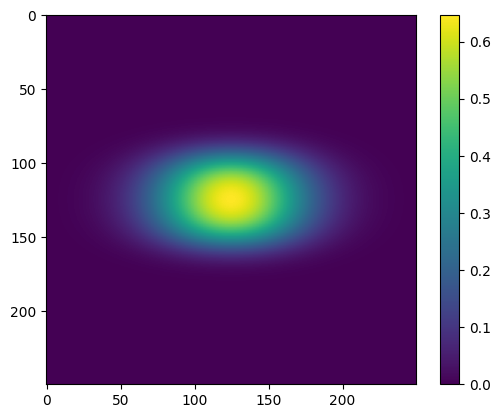

In [100]:
plt.imshow(history[-1].reshape(n, n))
print(len(history))
plt.colorbar()

# Неявная схема

In [232]:
def write_rhs(rhs):
    with open(f"rhs.mtx", "w") as f:
        f.write(f"%MatrixMarket matrix array real general\n")
        f.write(f"{N} {1}\n")
        for i in rhs:
            f.write(f"{i}\n")

In [244]:
n = 500
N = n * n
dx = 1
dy = 10
h = 1 / (n + 1)
delta_t = 0.001

In [245]:
def matrix_formation(n, N):
    with open(f"matrix.mtx", "w") as f:
        f.write(f"%MatrixMarket matrix coordinate real general\n")
        f.write(f"{N} {N} {N + 2 * (N - 1) + 2 * (N - n) - 2 * (n - 1)}\n")

        for i in range(1, N + 1):
            f.write(f"{i} {i} {(2 * dx + 2 * dy) / (h ** 2) + 1 / delta_t}\n")

        for i in range(2, N + 1):
            if (i % n != 1):
                f.write(f"{i} {i - 1} {-dy / (h ** 2)}\n")

        for i in range(2, N + 1):
            if (i % n != 1):
                f.write(f"{i - 1} {i} {-dy / (h ** 2)}\n")

        for i in range(n + 1, N + 1):
            f.write(f"{i} {i - n} {-dx / (h ** 2)}\n")

        for i in range(n + 1, N + 1):
            f.write(f"{i - n} {i} {-dx / (h ** 2)}\n")

In [246]:
history = []
matrix_formation(n, N)
u = np.zeros(N)


idx = 0
for i in range(1, n + 1): #строка
    for j in range(1, n + 1): #столбец
        u[idx] = initial(j * h, i * h)
        idx += 1
        
history.append(u)
write_rhs(history[-1]/ delta_t)

In [247]:
for i in range(10):
    print("Iter:", i)
    write_rhs(history[-1] / delta_t)
    os.system(f"./build/main {delta_t}")
    u = read_solution()
    history.append(u)

Iter: 0
Размер системы: 250000
ILU(2): 58077 ms
BiCGStab: 61079 ms
Number of iterations: 14
Residual: 3.51699e-05
Iter: 1
Размер системы: 250000
ILU(2): 58207 ms
BiCGStab: 68691 ms
Number of iterations: 16
Residual: 3.06041e-08
Iter: 2
Размер системы: 250000
ILU(2): 57236 ms
BiCGStab: 64034 ms
Number of iterations: 15
Residual: 2.29638e-08
Iter: 3
Размер системы: 250000
ILU(2): 56442 ms
BiCGStab: 67491 ms
Number of iterations: 16
Residual: 1.5827e-09
Iter: 4
Размер системы: 250000


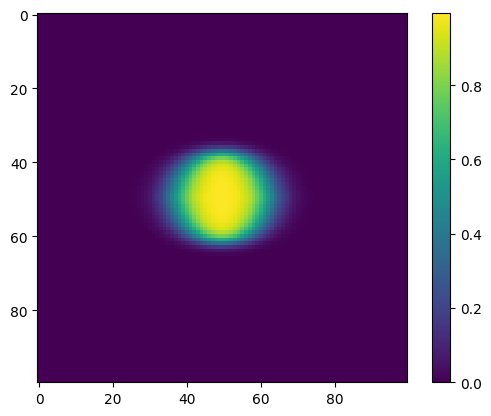

In [51]:
plt.imshow(history[-1].reshape(n, n))
len(history)
plt.colorbar()

# Анимация

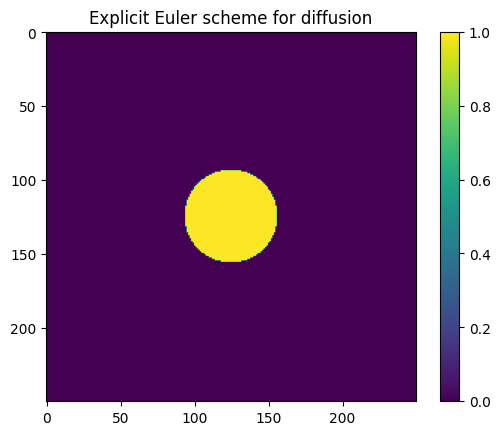

In [101]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Здесь должен быть ваш список матриц
matrices = history

fig, ax = plt.subplots()
ax.set_title("Explicit Euler scheme for diffusion")

Writer = matplotlib.animation.writers['ffmpeg']
Writer = Writer(fps=500, metadata=dict(artist="Me"), bitrate=-1)

# Создаем пустой график
#ax.set_title(f"t = {}")
image = ax.imshow(matrices[0].reshape(n, n))
fig.colorbar(image)

# Функция, которая будет обновлять график на каждом кадре анимации
def update(frame):
    image.set_array(matrices[frame].reshape(n, n))
    return image,

# Создаем анимацию
anim = FuncAnimation(fig, update, frames=len(matrices))

# Отображаем анимацию
anim.save("new.mp4", writer=Writer)